In [2]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
import statsmodels.formula.api as smf

from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [3]:
df = pd.read_excel('/content/drive/My Drive/Colab Notebooks/files/olympic_fato.xlsx')
noc = pd.read_csv('/content/drive/My Drive/Colab Notebooks/files/noc_regions.csv')
pib_df = pd.read_excel('/content/drive/My Drive/Colab Notebooks/files/country_gdp.xlsx')

In [4]:
df.info()
noc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314907 entries, 0 to 314906
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   edition      314907 non-null  object
 1   year         314907 non-null  int64 
 2   season       314907 non-null  object
 3   edition_id   314907 non-null  int64 
 4   country_noc  314907 non-null  object
 5   sport        314907 non-null  object
 6   event        314907 non-null  object
 7   result_id    314907 non-null  int64 
 8   athlete      314907 non-null  object
 9   athlete_id   314907 non-null  int64 
 10  pos          314907 non-null  object
 11  medal        314907 non-null  object
 12  isTeamSport  314907 non-null  bool  
dtypes: bool(1), int64(4), object(8)
memory usage: 29.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NOC     230 non-nu

In [5]:
noc_renamed = noc.rename(
    columns={"NOC": "country_noc"}
)

In [6]:
data = pd.merge(df,noc_renamed,how='left',on='country_noc')
data.head()

,edition,year,season,edition_id,country_noc,sport,event,result_id,athlete,athlete_id,pos,medal,isTeamSport,region,notes
0,1908 Summer Olympics,1908,Summer,5,ANZ,Athletics,"100 metres, Men",56265,Ernest Hutcheon,64710,DNS,na,False,Australia,Australasia
1,1908 Summer Olympics,1908,Summer,5,ANZ,Athletics,"400 metres, Men",56313,Henry Murray,64756,DNS,na,False,Australia,Australasia
2,1908 Summer Olympics,1908,Summer,5,ANZ,Athletics,"800 metres, Men",56338,Harvey Sutton,64808,3 h8 r1/2,na,False,Australia,Australasia
3,1908 Summer Olympics,1908,Summer,5,ANZ,Athletics,"800 metres, Men",56338,Guy Haskins,922519,DNS,na,False,Australia,Australasia
4,1908 Summer Olympics,1908,Summer,5,ANZ,Athletics,"800 metres, Men",56338,Joseph Lynch,64735,DNS,na,False,Australia,Australasia


In [7]:
summer = data.loc[data['edition'].str.contains('Summer', na=False)]

summer.rename(columns = {'region':'Country'}, inplace = True)

medals = summer.loc[summer['medal']!='na']

medals['Medal_Won'] = 1
medals['Team_Event'] = np.where(medals['isTeamSport'] == True,1,0)
medals['Individual_Event'] = np.where(medals.Team_Event,0,1)

medals.head()

,edition,year,season,edition_id,country_noc,sport,event,result_id,athlete,athlete_id,pos,medal,isTeamSport,Country,notes,Medal_Won,Team_Event,Individual_Event
20,1908 Summer Olympics,1908,Summer,5,ANZ,Athletics,"3,500 metres Race Walk, Men",56421,Harry Kerr,64719,3,Bronze,False,Australia,Australasia,1,0,1
30,1908 Summer Olympics,1908,Summer,5,ANZ,Boxing,"Middleweight, Men",21263,Snowy Baker,45153,2,Silver,False,Australia,Australasia,1,0,1
32,1908 Summer Olympics,1908,Summer,5,ANZ,Rugby,"Rugby, Men",31505,John Barnett,11237,1,Gold,True,Australia,Australasia,1,1,0
33,1908 Summer Olympics,1908,Summer,5,ANZ,Rugby,"Rugby, Men",31505,Phil Carmichael,11239,1,Gold,True,Australia,Australasia,1,1,0
34,1908 Summer Olympics,1908,Summer,5,ANZ,Rugby,"Rugby, Men",31505,Dan Carroll,11240,1,Gold,True,Australia,Australasia,1,1,0


In [32]:
medals_tally = medals.groupby(['year', 'country_noc', 'Country','sport','event', 'medal'])[['Medal_Won', 'Team_Event','Individual_Event']].agg('sum').reset_index()

medals_tally['Medal_Count'] = medals_tally['Medal_Won']/(medals_tally['Team_Event']+medals_tally['Individual_Event'])

medals_tally['Sex'] = 'M'

medals_tally.loc[medals_tally['event'].str.contains('Women'),'Sex']='F'

medals_tally = medals_tally.loc[medals_tally['year'] >= 1972]

medals_tally.sort_values(['year'],ascending = [True],inplace=True)

medals_tally = medals_tally[(medals_tally['Country'] != 'Taiwan')]
medals_by_country = medals_tally.loc[medals_tally['year']>=1972].groupby(['year','country_noc','Country'])['Medal_Count'].sum().reset_index()

medals_by_country.head()

,year,country_noc,Country,Medal_Count
0,1972,ARG,Argentina,1.0
1,1972,AUS,Australia,17.0
2,1972,AUT,Austria,3.0
3,1972,BEL,Belgium,2.0
4,1972,BRA,Brazil,2.0


In [12]:
pib = pib_df[['country','1972', '1976', '1980', '1984','1988', '1992', '1996', '2000', '2004','2008','2012', '2016', '2020']]
pib.rename(columns={'country':'Country'},inplace=True)

pib = pd.melt(pib, 
            id_vars='Country', 
            value_vars=list(pib.columns[1:]), 
            var_name='Year', 
            value_name='PIB')

pib['Year'] = pib['Year'].str.replace(',', '').astype(float).astype(int)

pib.sort_values(['Country','Year'],ascending = [True,True],inplace=True)

pib.rename(columns={'Year':'year'},inplace=True)

pib.head()

,Country,year,PIB
2,Afghanistan,1972,1.595555e+09
268,Afghanistan,1976,2.555556e+09
534,Afghanistan,1980,3.641723e+09
800,Afghanistan,1984,NaN
1066,Afghanistan,1988,NaN


In [13]:
to_replace = ['Bahamas, The','Egypt, Arab Rep.','Iran, Islamic Rep.',"Cote d'Ivoire",'Kyrgyz Republic','North Macedonia',
             'Korea, Dem. People’s Rep.','Russian Federation','Slovak Republic','Korea, Rep.','Syrian Arab Republic',
              'Trinidad and Tobago','United Kingdom','United States','Venezuela, RB','Virgin Islands (U.S.)', 'Bolivia', 
              'Antigua and Barbuda', 'Brunei Darussalam', 'Cabo Verde', 'British Virgin Islands', 'Czechia', 'Congo, Dem. Rep.',  'Lao PDR',
              'Gambia, The',  'World', 'Micronesia, Fed. Sts.',  "Korea, Dem. People's Rep.", 'Congo, Rep.', 'St. Kitts and Nevis','St. Lucia',
              'St. Vincent and the Grenadines', 'Turkiye']
            

new_countries =   ['Bahamas','Egypt', 'Iran', 'Ivory Coast','Kyrgyzstan','Macedonia','North Korea','Russia','Slovakia',
                   'South Korea','Syria','Trinidad','UK','USA','Venezuela','Virgin Islands, US', 'Boliva', 
                   'Antigua', 'Brunei', 'Cape Verde', 'Virgin Islands, British', 'Czech Republic', 'Democratic Republic of the Congo', 'Laos',
                   'Gambia', 'Individual Olympic Athletes', 'Micronesia','North Korea', 'Republic of Congo',  'Saint Kitts','Saint Lucia',
                   'Saint Vincent',  'Turkey']

pib.replace(to_replace,new_countries,inplace=True)

In [14]:
medals_tally_pib = medals_by_country.merge(pib,
                                   left_on = ['year', 'Country'],
                                   right_on = ['year', 'Country'],
                                   how = 'left')
medals_tally_pib.head()

,year,country_noc,Country,Medal_Count,PIB
0,1972,ARG,Argentina,1.0,3.473300e+10
1,1972,AUS,Australia,17.0,5.204206e+10
2,1972,AUT,Austria,3.0,2.205961e+10
3,1972,BEL,Belgium,2.0,3.720942e+10
4,1972,BRA,Brazil,2.0,5.843486e+10


In [34]:
team_size = summer.loc[summer.year >= 1972].drop_duplicates().groupby(['year', 'Country']).athlete_id.count().reset_index(name='Team_Size')
train = medals_tally_pib.merge(team_size,left_on=['year','Country'],right_on=['year','Country'],how='left')
train['Log_PIB'] = train['PIB'].apply(np.log)
train.head()

,year,country_noc,Country,Medal_Count,PIB,Team_Size,Log_PIB
0,1972,ARG,Argentina,1.0,3.473300e+10,136,24.270956
1,1972,AUS,Australia,17.0,5.204206e+10,286,24.675318
2,1972,AUT,Austria,3.0,2.205961e+10,148,23.817014
3,1972,BEL,Belgium,2.0,3.720942e+10,108,24.339828
4,1972,BRA,Brazil,2.0,5.843486e+10,109,24.791178


<Axes: >

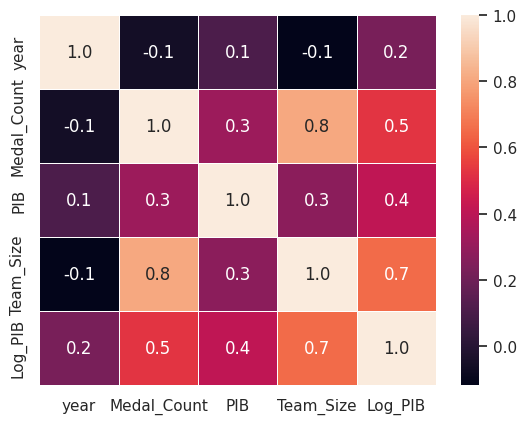

In [18]:
correlation = train.corr()
plot = sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=.6)
plot

Text(22.7, 150, 'Correlação = 0.5962511389944435')

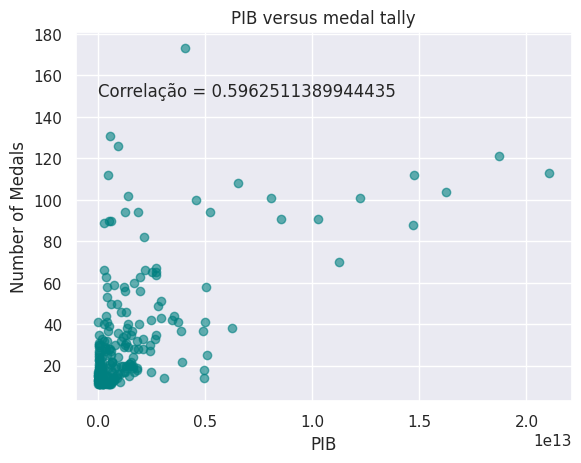

In [35]:
corr_pib = train.loc[train['Medal_Count']>10.0,['PIB', 'Medal_Count']].corr()['Medal_Count'][0]

plt.plot(train.loc[train['Medal_Count']>10.0,  'PIB'], 
     train.loc[train['Medal_Count']>10.0,  'Medal_Count'] , 
     linestyle = 'none', 
     marker = 'o',
    color = 'teal',
    alpha = 0.6)
plt.xlabel('PIB')
plt.ylabel('Number of Medals')
plt.title('PIB versus medal tally')
plt.text(22.7, 
     150,
     "Correlação = " + str(corr_pib))

Text(22.7, 150, 'Correlação = 0.5220418703428111')

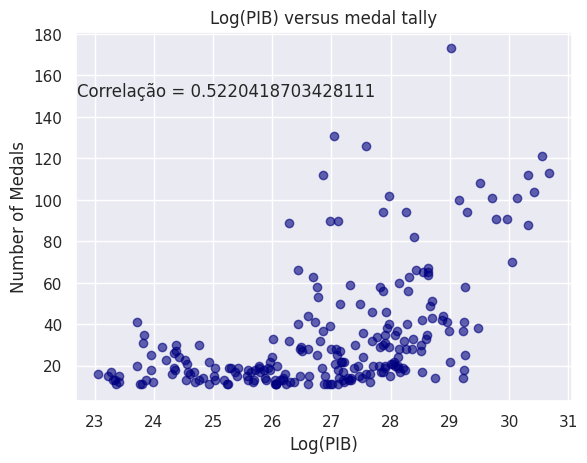

In [36]:
corr_pib_log = train.loc[train['Medal_Count']>10.0,['Log_PIB', 'Medal_Count']].corr()['Medal_Count'][0]

plt.plot(train.loc[train['Medal_Count']>10.0,  'Log_PIB'], 
     train.loc[train['Medal_Count']>10.0,  'Medal_Count'] , 
     linestyle = 'none', 
     marker = 'o',
    color = 'navy',
    alpha = 0.6)
plt.xlabel('Log(PIB)')
plt.ylabel('Number of Medals')
plt.title('Log(PIB) versus medal tally')
plt.text(22.7, 
     150,
     "Correlação = " + str(corr_pib_log))

Text(50, 150, 'Correlação = 0.7062791532146699')

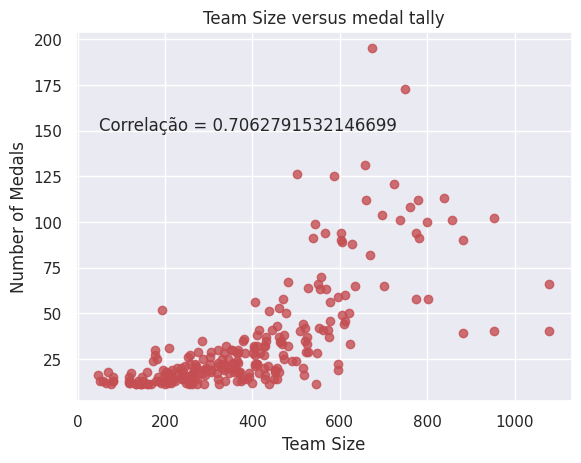

In [37]:
corr_team = train.loc[train['Medal_Count']>10.0,['Team_Size', 'Medal_Count']].corr()['Medal_Count'][0]

plt.plot(train.loc[train['Medal_Count']>10.0,  'Team_Size'], 
     train.loc[train['Medal_Count']>10.0,  'Medal_Count'] , 
     linestyle = 'none', 
     marker = 'o',
         color='r',
    alpha = 0.8)
plt.xlabel('Team Size')
plt.ylabel('Number of Medals')
plt.title('Team Size versus medal tally')
plt.text(50,150,
     "Correlação = " + str(corr_team))

In [38]:
#train models on data upto 2016
X_tr = train.loc[train.year != 2020].dropna()[['Team_Size']]
y_tr = train.loc[train.year != 2020].dropna()['Medal_Count']
#predict on 2020
X_tst = train.loc[train.year == 2020].dropna()[['Team_Size']]
y_tst = train.loc[train.year == 2020].dropna()['Medal_Count']

In [39]:
lr = LinearRegression()
lr.fit(X_tr,y_tr)
y_pred = lr.predict(X_tst)

lr_score = lr.score(X_tst,y_tst) #this gives the R^2 score
lr_err = np.sqrt(mse(y_tst,y_pred)) #this gives the rms error

print('Linear Regression R^2: {}, Linear Regression RMSE: {}'.format(lr_score,lr_err))

Linear Regression R^2: 0.7268160795952181, Linear Regression RMSE: 9.549311563974817


In [40]:
OLS = smf.ols('Medal_Count ~ Team_Size ', data=train.loc[train.year!=2020]).fit()

y_ols = OLS.predict(X_tst)
ols_score = OLS.rsquared #R^2
ols_err = np.sqrt(mse(y_tst, y_ols)) #rms error
print('Statsmodels OLS R^2: {}, Statsmodels OLS RMSE: {}'.format(ols_score,ols_err))

Statsmodels OLS R^2: 0.644068256754482, Statsmodels OLS RMSE: 9.653038165102611


In [41]:
X = train['Team_Size'].values
Y = train['Medal_Count'].values

Z = train['Log_PIB'].values

W = train['PIB'].values

Text(20, 150, 'r² = 0.727')

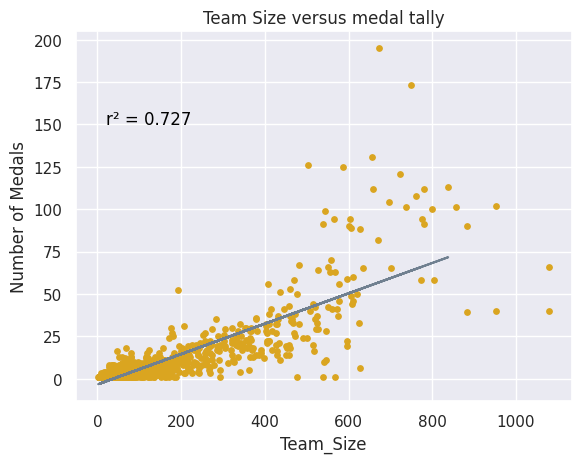

In [43]:
plt.scatter(X, Y, color="goldenrod", s=15)
plt.plot(X_tst, y_pred, color="slategray")
plt.xlabel('Team_Size')
plt.ylabel('Number of Medals')
plt.title('Team Size versus medal tally')
plt.text(20,150,"r² = " + str(round(lr_score, 3)), color="black")